In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import sys
import os
from tqdm.notebook import tqdm
sys.path.append('..')
from mask_rcnn import dataloader
from mask_rcnn.hyperparameters import mask_rcnn_params
from mask_rcnn.hyperparameters import dataset_params
from mask_rcnn import tf2_model
from mask_rcnn import mask_only
from mask_rcnn.training import losses
import matplotlib.pyplot as plt

In [2]:
os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=fusible"
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

In [3]:
data_params = dataset_params.get_data_params()
data_params['image_size'] = [832, 1344]
model_params = mask_rcnn_params.default_config().values()
model_params['finetune_bn'] = False
model_params['use_batched_nms'] = True
model_params['train_batch_size'] = data_params['batch_size']
model_params['l2_weight_decay'] = 1e-4
model_params['include_mask'] = True
train_data = '/workspace/shared_workspace/data/coco/train*'

In [4]:
data = dataloader.InputReader(train_data, use_instance_mask=True)
train_tdf = data(data_params)

In [5]:
model = tf2_model.MaskRCNN(model_params)
#model = mask_only.MaskRCNN(model_params)

In [6]:
train_gen = iter(train_tdf.prefetch(128))

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = mixed_precision.LossScaleOptimizer(optimizer, loss_scale='dynamic')

In [8]:
@tf.function
def train_step(features, labels, params):
    with tf.GradientTape() as tape:
        model_outputs = model(features, labels)
        # rpn loss
        total_rpn_loss, rpn_score_loss, rpn_box_loss = losses.rpn_loss(
            score_outputs=model_outputs['rpn_score_outputs'],
            box_outputs=model_outputs['rpn_box_outputs'],
            labels=labels,
            params=model_params
        )
        # frcnn loss
        total_fast_rcnn_loss, fast_rcnn_class_loss, fast_rcnn_box_loss = losses.fast_rcnn_loss(
            class_outputs=model_outputs['class_outputs'],
            box_outputs=model_outputs['box_outputs'],
            class_targets=model_outputs['class_targets'],
            box_targets=model_outputs['box_targets'],
            params=model_params
        )
        '''total_fast_rcnn_loss = 0
        fast_rcnn_class_loss = 0
        fast_rcnn_box_loss = 0'''
        # mask loss
        if params['include_mask']:
            mask_loss = losses.mask_rcnn_loss(
                mask_outputs=model_outputs['mask_outputs'],
                mask_targets=model_outputs['mask_targets'],
                select_class_targets=model_outputs['selected_class_targets'],
                params=model_params
            )
        else:
            mask_loss = 0
        # l2 decay
        trainable_variables = model.trainable_variables
        l2_regularization_loss = model_params['l2_weight_decay'] * tf.add_n([
            tf.nn.l2_loss(v)
            for v in trainable_variables
            if not any([pattern in v.name for pattern in ["batch_normalization", "bias", "beta"]])
        ])
        total_loss = total_rpn_loss + total_fast_rcnn_loss + mask_loss + l2_regularization_loss
        scaled_loss = optimizer.get_scaled_loss(total_loss)
    scaled_gradients = tape.gradient(scaled_loss, model.trainable_variables)
    gradients = optimizer.get_unscaled_gradients(scaled_gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

In [26]:
features, labels = next(train_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


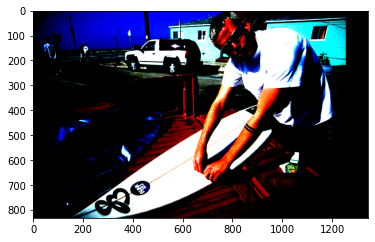

In [27]:
plt.imshow(features['images'][0])

In [31]:
labels['gt_boxes'][0]

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[ 9.4973583e+00,  6.3971667e+02,  6.9903699e+02,  1.2110946e+03],
       [ 1.3708377e+02,  1.8213188e+02,  2.0845132e+02,  2.1407555e+02],
       [ 1.0470641e+02,  4.4846638e+01,  2.6735849e+02,  1.2332336e+02],
       [ 1.3308076e+02,  2.0183929e+02,  2.0984454e+02,  2.3456734e+02],
       [ 3.7290869e+02,  1.6479720e+02,  8.1889209e+02,  9.6813440e+02],
       [ 2.2112755e+02,  0.0000000e+00,  3.2275320e+02,  7.0162346e+01],
       [ 2.1257207e+02,  1.1557373e+03,  2.8282114e+02,  1.2116633e+03],
       [ 1.1808906e+02,  3.6591095e+02,  2.5674265e+02,  6.8203363e+02],
       [ 2.5933282e+02,  2.1570313e+00,  8.1471246e+02,  1.2550000e+03],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
 

In [36]:
train_step(features, labels, model_params)

<tf.Tensor: shape=(), dtype=float32, numpy=8.052017>

In [ ]:
progressbar = tqdm(range(4096))
loss_history = []
for i in progressbar:
    features, labels = next(train_gen)
    loss = train_step(features, labels, model_params)
    loss_history.append(loss.numpy())
    progressbar.set_description("Loss: {0:.4f}".format(np.array(loss_history[-50:]).mean()))

In [15]:
progressbar = tqdm(range(64))
loss_history = []
tf.profiler.experimental.start('/workspace/shared_workspace/logs/single_batch/split_image')
for i in progressbar:
    #features, labels = next(train_gen)
    loss = train_step(features[i], labels[i], model_params)
    loss_history.append(loss.numpy())
    progressbar.set_description("Loss: {0:.4f}".format(np.array(loss_history[-50:]).mean()))
tf.profiler.experimental.stop()

In [14]:
432*18

7776

In [15]:
118000/256

460.9375